# Unconstrained minimization
*not completely finished*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## Gradient and Newton method
$$\text{minimize } f(x)=-\sum_{i=1}^{m}log(1-a_i^Tx)-\sum_{i=1}^nlog(1-x_i^2)$$
Implicit constraints:
1. $\forall i=1,2,\ldots,m, \quad a_i^Tx < 1$
2. $\forall j=1,2,\ldots,n, \quad |x_j| < 1$

Define $y=1-Ax$, $z=1-x^2$ (element-wise):
$$\nabla f(x)=A^T \frac{1}{y} + \frac{2x}{z}$$
$$\nabla^2 f(x)= A^T \text{diag}(\frac{1}{y^2}) A + \text{diag}[\frac{2(1+x^2)}{(1-x^2)^2}]$$

In [2]:
n = 100
m = 200
A = np.random.randn(m, n)

def in_domain(x: np.ndarray):
    y = 1 - A @ x
    z = 1 - np.square(x)
    return np.all(y > 0) and np.all(z > 0)

def f(x: np.ndarray):
    if not in_domain(x):
        return None
    y = 1 - A @ x
    z = 1 - x ** 2
    return -np.log(np.prod(y)) - np.log(np.prod(z))

def grad_f(x: np.ndarray):
    if not in_domain(x):
        return None
    y = 1 - A @ x
    z = 1 - x ** 2
    return A.T @ (1 / y) + x * (2 / z)

def hessian_f(x: np.ndarray):
    if not in_domain(x):
        return None
    y = 1 - A @ x
    lam = 1 / y ** 2
    dg = 2 * (1 + x ** 2) / (1 - x ** 2) ** 2
    return A.T @ np.diag(lam.reshape((m,))) @ A + np.diag(dg.reshape(n,))

### Gradient descent
repeat:
1. $\Delta x=-\nabla f(x)$
2. line search for $t(\alpha, \beta)$
3. $x := x + t\Delta x$  
until $\|\nabla f(x)\|_2 \leq \epsilon$

In [3]:
def gradient_descent(x0: np.ndarray, alpha: float, beta: float, eps: float):
    assert 0 < alpha < 0.5 and 0 < beta < 1
    assert in_domain(x0)
    x = x0
    cnt = 0
    loss = []

    while True:
#         print("step = %d,\t f(x) = %.4f" % (cnt, f(x)))
        loss.append(f(x))
        cnt += 1
        dx = - grad_f(x)
        # line search
        t = 1
        while True:
            x_next = x + t * dx
            if in_domain(x_next) and f(x_next) < f(x) - alpha * t * np.sum(dx ** 2):
                break
            t = beta * t
        x = x + t * dx
        if np.linalg.norm(dx, 2) <= eps:
            break
    return x, np.array(loss)

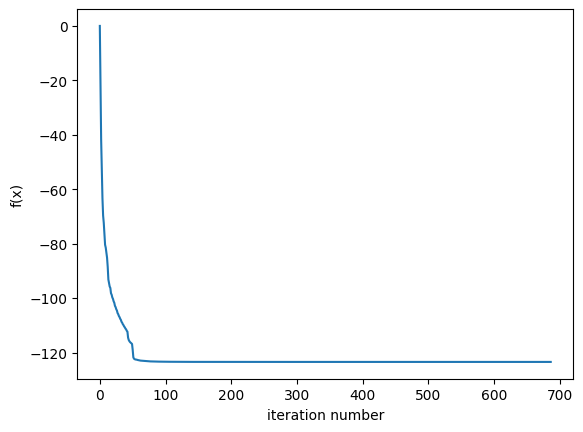

optimal value using gradient: 	 -123.4448


In [4]:
alpha = 0.25
beta = 0.5
eps = 1e-4
x_star, loss = gradient_descent(x0=np.zeros((n, 1)), alpha=alpha, beta=beta, eps=eps)

plt.plot(loss)
plt.ylabel("f(x)")
plt.xlabel("iteration number")
plt.show()
plt.close()
print("optimal value using gradient: \t %.4f" % f(x_star))

### Newton method
repeat:
1. $\Delta x=-\nabla^2 f(x)^{-1} \nabla f(x)$, $\lambda^2 = \nabla f(x)^T \nabla^2 f(x)^{-1} \nabla f(x)$
2. line search for $t(\alpha, \beta)$
3. $x = x + t\Delta x$  
until $\lambda^2 \leq 2\epsilon$

In [5]:
def newton(x0: np.ndarray, alpha: float, beta: float, eps: float):
    cnt, x = 0, x0
    loss = []
    while True:
#         print("f(x) = %.4f" % f(x))
        grad = grad_f(x)
        hessian = np.linalg.inv(hessian_f(x))
        dx = - hessian @ grad
        l2 = grad.T @ hessian @ grad
        loss.append(l2.item())
        if l2 <= 2 * eps:
            break

        t = 1
        while True:
            x_next = x + t * dx
            if in_domain(x_next) and f(x_next) < f(x) - alpha * t * np.sum(dx ** 2):
                break
            t = beta * t
        x = x + t * dx
    return x, loss

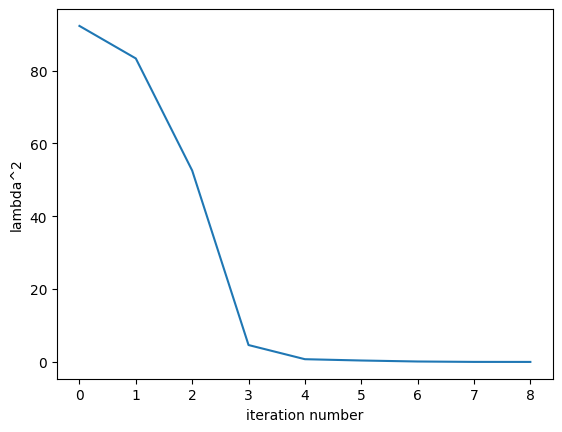

optimal value using newton method: 	 -123.4448


In [6]:
alpha = 0.25
beta = 0.5
eps = 1e-4
x_star, loss = newton(x0=np.zeros((n, 1)), alpha=alpha, beta=beta, eps=eps)

plt.plot(loss)
plt.ylabel("lambda^2")
plt.xlabel("iteration number")
plt.show()
plt.close()
print("optimal value using newton method: \t %.4f" % f(x_star))

## Online advertising displays

In [7]:
from scipy.io import loadmat
# loading data
data = loadmat("ad_data.mat")
m, n, T = data['m'][0, 0], data['n'][0, 0], data['T'][0, 0]
p, q, = data['p'].reshape((m,)), data['q'].reshape((m,))
Acontr, Tcontr = data['Acontr'], data['Tcontr']
I = data['I'].reshape((T,))
R = data['R']

In [8]:
N = cp.Variable((n, T))
cst = [cp.sum(N, axis=0) == I, N >= 0]

# optimal, considering penalty
s = cp.pos(q - cp.diag(Tcontr.T @ N.T @ Acontr))
obj = cp.Maximize(cp.trace(R.T @ N) - p.T @ s)
prob = cp.Problem(obj, cst)

opt_profit = prob.solve()
opt_revenue = np.trace(R.T @ N.value)
opt_penalty = opt_revenue - opt_profit

# greedy, no penalty in objective function
obj2 = cp.Maximize(cp.trace(R.T @ N))
prob2 = cp.Problem(obj2, cst)

greedy_revenue = prob2.solve()
greedy_penalty = p.T @ (q - np.diag(Tcontr.T @ N.value.T @ Acontr))
greedy_penalty = np.maximum(greedy_penalty, 0)
greedy_profit = greedy_revenue - greedy_penalty

print("\nOptimal condition, \t Greedy condition:")
print("profit: \t %.3f \t %.3f" % (opt_profit, greedy_profit))
print("revenue: \t %.3f \t %.3f" % (opt_revenue, greedy_revenue))
print("penalty: \t %.3f \t %.3f" % (opt_penalty, greedy_penalty))


Optimal condition, 	 Greedy condition:
profit: 	 230.566 	 96.427
revenue: 	 268.232 	 305.102
penalty: 	 37.666 	 208.675


## Ranking by aggregating preferences

In [9]:
data = loadmat("preferences_data.mat")
m, n = data['m'][0, 0], data['n'][0, 0]
pref = data['preferences']          # m x 2

In [13]:
P = np.zeros((m, n))
for i in range(m):
    P[i, pref[i, 0] - 1] = -1
    P[i, pref[i, 1] - 1] = 1

r = cp.Variable(n)
v = cp.pos(P @ r + 1)
obj1 = cp.Minimize(cp.sum(v))
obj2 = cp.Minimize(cp.sum(cp.square(v)))
prob1 = cp.Problem(obj1, [])
prob2 = cp.Problem(obj2, [])

prob1.solve()
v1 = np.maximum(P @ r.value + 1, 0)

prob2.solve()
v2 = np.maximum(P @ r.value + 1, 0)

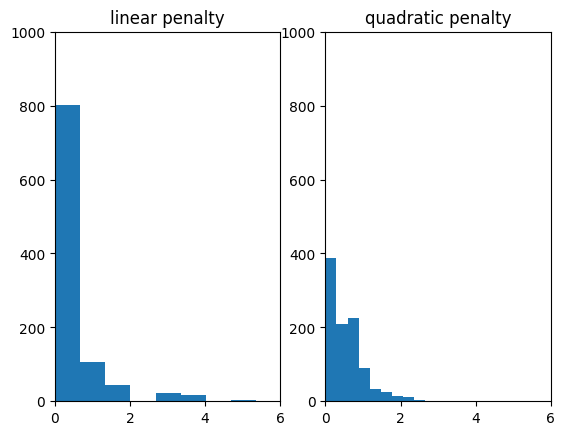

In [14]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(v1)
axes[0].set_xlim(0, 6)
axes[0].set_ylim(0, 1000)
axes[0].set_title("linear penalty")

axes[1].hist(v2)
axes[1].set_xlim(0, 6)
axes[1].set_ylim(0, 1000)
axes[1].set_title("quadratic penalty")

plt.show()
plt.close()